In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar
import theano.tensor as tt


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [3]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [20]:
AA,DD = 1.0,1.0
dt = 0.01
tau_real = AA/DD
N=10000 # length of data set
data = langevin.time_series(A=AA, D=DD, delta_t=dt, N=N)
time = np.arange(N)*dt

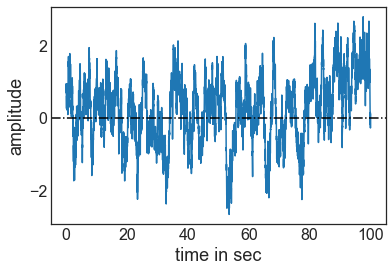

In [40]:
plt.plot(time,data)
plt.axhline(y=0, color='k', linestyle='-.')
plt.xlabel("time in sec")
plt.ylabel("amplitude")
plt.savefig("OUdata.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [28]:
fitA,fitdA,fitTau,fitdTau = OUresult1(data,0.01)

In [29]:
print(fitA,fitdA,fitTau,fitdTau)

1.109179449178907 0.16309276954383486 1.1028508374793942 0.16289918623903987


In [30]:
fitD = fitA/fitTau
fitdD = np.sqrt(fitdA**2/fitTau**2+fitA**2*fitdTau**2/fitTau**4)

In [31]:
print(fitA,fitdA,fitD,fitdD)

1.109179449178907 0.16309276954383486 1.0057384112922987 0.2096137572512661


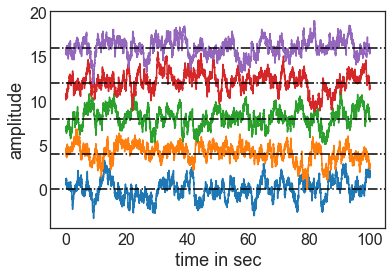

In [41]:
for i in range(5):
    data = langevin.time_series(A=fitA, D=fitD, delta_t=dt, N=N)
    plt.plot(time,data+4*i)
    plt.axhline(y=4*i, color='k', linestyle='-.')
plt.xlabel("time in sec")
plt.ylabel("amplitude")
plt.savefig("OUresult.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")